# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import statsmodels.stats.api as sms
import glob
import tikzplotlib as tpl
from pathlib import Path

In [2]:
def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [3]:
def _pkl_to_csv(basepath, num_questions, make_dirs=True):
    num_diss_files = len(glob.glob(f"{basepath}random_order_disson_*.pkl"))

    if make_dirs is True:
        for i in range(num_diss_files):
            Path(f"{basepath}csv/{i}").mkdir(
                parents=True, exist_ok=True
            )

    for i in tqdm(range(num_diss_files)):
        disson = pd.read_pickle(
            f"{basepath}random_order_disson_{i}.pkl"
        )

        [
            _diss_dataset(
                disson, questions, groups=["qsampled", "m2", "runif", "actual"]
            ).to_csv(
                f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions}.csv",
                index=False,
            )
            for questions in range(1, num_questions)
        ]    

def _process_csvs(basepath, num_questions, dffg = None, dffgm = None, dd = None, get_csvs=False,):
    if get_csvs is True:
        _pkl_to_csv(basepath, num_questions)

    num_diss_files = len(glob.glob(f"{basepath}random_order_disson_*.pkl"))

    if dffg is None:
        dffg = pd.concat(
            [
                pd.concat(
                    [
                        pd.read_csv(
                            f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions_asked}.csv"
                        ).iloc[:, np.r_[:questions_asked]],
                        # .mean(axis=1, numeric_only=True),
                        pd.read_csv(
                            f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions_asked}.csv"
                        )["y"],
                    ],
                    axis=1,
                )
                # .groupby("y", as_index=False)
                # .mean()
                .assign(questions=str(questions_asked))
                for questions_asked in range(1, num_questions)
                for i in range(num_diss_files)
            ]
        )
        dffg.to_csv(f"{basepath}dffg.csv", index=False)

    if dffgm is None:
        pivot_list = list()
        chunk_size = 100000

        for i in tqdm(range(0, len(dffg), chunk_size)):
            row_pivot = (
                dffg.iloc[i : i + chunk_size]
                .melt(id_vars=["y", "questions"])
                .query("~value.isna()")
                .assign(
                    questions=lambda x: x["questions"].astype(int),
                    variable=lambda x: x["variable"].astype(int),
                )
            )
            pivot_list.append(row_pivot)

        dffgm = pd.concat(pivot_list, copy=False)
        dffgm.to_csv(f"{basepath}dffgm.csv", index=False)

    if dd is None:
        pivot_list = list()
        chunk_size = 100000

        for i in tqdm(range(0, len(dffg), chunk_size)):
            row_pivot = pd.concat(
                [
                    dffg.drop(["y", "questions"], axis="columns")
                    .iloc[i : i + chunk_size]
                    .mean(axis=1),
                    dffg.iloc[i : i + chunk_size]["y"],
                    dffg.iloc[i : i + chunk_size]["questions"],
                ],
                axis=1,
            ).set_axis(["dissonance", "y", "questions"], axis="columns")
            pivot_list.append(row_pivot)

        dd = pd.concat(pivot_list, copy=False)
        dd.to_csv(f"{basepath}dd.csv", index=False)

def _plot_diss_dist(dffgm, dd, num_questions, outfile, plots = ["diss-comp", "diss-distr"], outfig=None):
    
    if "diss-comp" in plots:
        res_gdf = list()
        conf = 0.95
        for questions in tqdm(range(1, num_questions)):
            for group in ["qsampled", "runif", "m2", "actual"]:
                dfgq = dffgm.query("questions==@questions & y==@group")
                mean = dfgq["value"].mean()
                var = dfgq["value"].var()
                ci = sms.DescrStatsW(dfgq["value"]).tconfint_mean(alpha=1 - conf)
                res_gdf.append([group, questions, mean, var, ci[0], ci[1]])

        res_gdf = pd.DataFrame(
            res_gdf, columns=["variable", "questions", "mean", "var", "lower", "upper"]
        )

        res_gdf

        for v in ["qsampled", "m2", "runif", "actual"]:
            df = res_gdf.query("variable==@v")
            plt.plot(df["questions"], df["mean"])
            plt.fill_between(df["questions"], df["lower"], df["upper"], alpha=0.3)
        if outfig is not None:
            plt.savefig(f"{outfig}diss_comp.png")

        res_gdf.to_csv(
            outfile,
            index=False,
        )

    if "diss-distr" in plots:
        ddp = dd

        fig, ax = plt.subplots()
        sns.histplot(
            ddp.reset_index(),
            x="dissonance",
            hue="y",
            ax=ax,
            element="step",
            stat="density",
            common_norm=False,
            kde=False,
        )
        if outfig is not None:
            plt.savefig(f"{outfig}diss_distr.png")

        tpl.save(
        figure=fig,
        filepath=f"{outfig}diss_distr.tex",
        extra_axis_parameters=[
            "basegridstyle",
            "ignore legend",
            ],
            standalone=False,
        )

# PTSD

## Old

In [2]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_samples*.pkl")
]

In [19]:
groups = ["qsampled", "m2", "runif"]

questions_asked = 211
data = _diss_dataset(diss[0], questions_asked, groups=groups).iloc[
    :, np.r_[:questions_asked, -1]
]

data_mean = pd.concat([data.mean(axis=1, numeric_only=True), data["y"]], axis=1)

data_mean

,0,y
0,0.265125,qsampled
1,0.281185,qsampled
2,0.307649,qsampled
3,0.316200,qsampled
4,0.286729,qsampled
...,...,...
95,0.375461,runif
96,0.444167,runif
97,0.431583,runif
98,0.429709,runif


In [20]:
pd.melt(data_mean, id_vars="y")

,y,variable,value
0,qsampled,0,0.265125
1,qsampled,0,0.281185
2,qsampled,0,0.307649
3,qsampled,0,0.316200
4,qsampled,0,0.286729
...,...,...,...
295,runif,0,0.375461
296,runif,0,0.444167
297,runif,0,0.431583
298,runif,0,0.429709


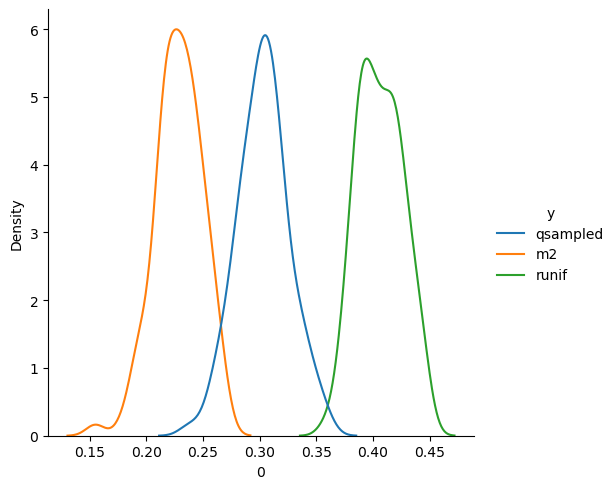

In [23]:
sns.displot(data=data_mean, x=0, hue="y", kind="kde")

In [2]:
dffp = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmr_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmr_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 212)
        for i in range(10)
    ]
)

dd = pd.concat(
    [
        dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffp["y"],
        dffp["questions"],
    ],
    axis=1,
)

In [25]:
dffp

,0,y,questions,1,2,3,4,5,6,7,...,201,202,203,204,205,206,207,208,209,210
0,0.000000,qsampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.726744,qsampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.726744,qsampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.668605,qsampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.883721,qsampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,runif,211,0.939211,0.275589,0.323147,0.811179,0.794269,0.000000,0.000000,...,0.332935,0.000000,0.552130,0.267945,0.893588,0.907395,0.739432,0.000000,0.000000,0.219646
296,0.000000,runif,211,0.855016,0.253813,0.243242,0.902449,0.782748,0.000000,0.415322,...,0.891940,0.701597,0.000000,0.308317,0.000000,0.000000,0.000000,0.388393,0.000000,0.757905
297,0.311966,runif,211,0.841182,0.517709,0.561542,0.896534,0.412218,0.138291,0.587463,...,0.516637,0.284330,0.354784,0.320342,0.803036,0.574438,0.429181,0.729010,0.878173,0.277719
298,0.354038,runif,211,0.000000,0.000000,0.000000,0.000000,0.754013,0.840412,0.000000,...,0.606713,0.381820,0.821148,0.579592,0.598435,0.888045,0.248206,0.309154,0.319224,0.749744


In [26]:
dffpm = (
    pd.melt(dffp, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dffpm

,y,questions,variable,value
0,qsampled,1,0,0.000000
1,qsampled,1,0,0.726744
2,qsampled,1,0,0.726744
3,qsampled,1,0,0.668605
4,qsampled,1,0,0.883721
...,...,...,...,...
133562995,runif,211,210,0.219646
133562996,runif,211,210,0.757905
133562997,runif,211,210,0.277719
133562998,runif,211,210,0.749744


In [34]:
dffp.drop(["y", "questions"], axis="columns")

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.726744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.726744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.668605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.883721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,0.939211,0.275589,0.323147,0.811179,0.794269,0.000000,0.000000,0.000000,0.000000,...,0.332935,0.000000,0.552130,0.267945,0.893588,0.907395,0.739432,0.000000,0.000000,0.219646
296,0.000000,0.855016,0.253813,0.243242,0.902449,0.782748,0.000000,0.415322,0.118827,0.424644,...,0.891940,0.701597,0.000000,0.308317,0.000000,0.000000,0.000000,0.388393,0.000000,0.757905
297,0.311966,0.841182,0.517709,0.561542,0.896534,0.412218,0.138291,0.587463,0.000000,0.196209,...,0.516637,0.284330,0.354784,0.320342,0.803036,0.574438,0.429181,0.729010,0.878173,0.277719
298,0.354038,0.000000,0.000000,0.000000,0.000000,0.754013,0.840412,0.000000,0.516927,0.904079,...,0.606713,0.381820,0.821148,0.579592,0.598435,0.888045,0.248206,0.309154,0.319224,0.749744


In [4]:
dd = pd.concat(
    [
        dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffp["y"],
        dffp["questions"],
    ],
    axis=1,
)

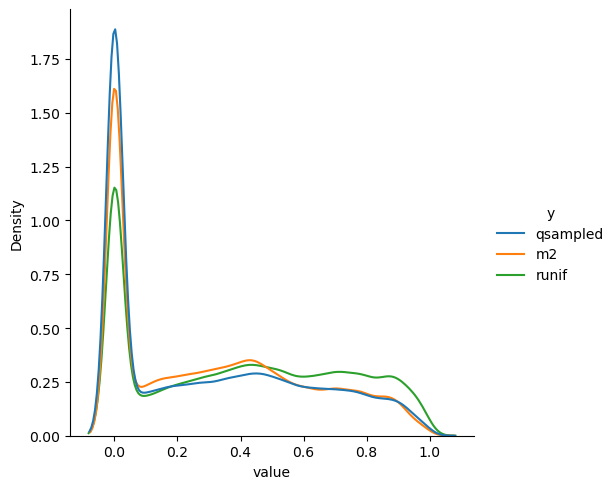

In [28]:
sns.displot(data=dffpm.query("questions==211"), x="value", hue="y", kind="kde")

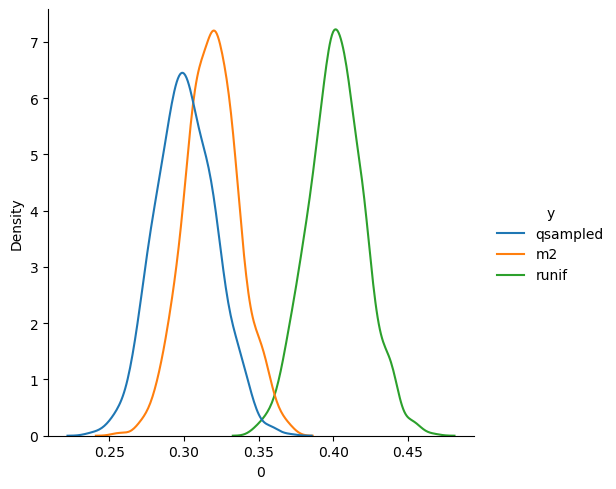

In [40]:
sns.displot(
    data=pd.concat(
        [
            dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
            dffp["y"],
            dffp["questions"],
        ],
        axis=1,
    ).query("questions=='211'"),
    x=0,
    hue="y",
    kind="kde",
)

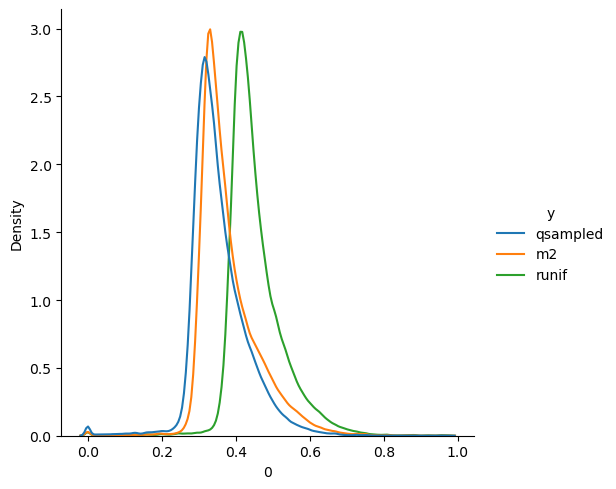

In [41]:
sns.displot(
    data=pd.concat(
        [
            dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
            dffp["y"],
            dffp["questions"],
        ],
        axis=1,
    ),
    x=0,
    hue="y",
    kind="kde",
)

In [44]:
pd.concat(
    [
        dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffp["y"],
        dffp["questions"],
    ],
    axis=1,
).to_csv("data/ptsd/disson_qmr_ptsd_random_order_mean_dissonances.csv", index=False)

<BarContainer object of 20 artists>

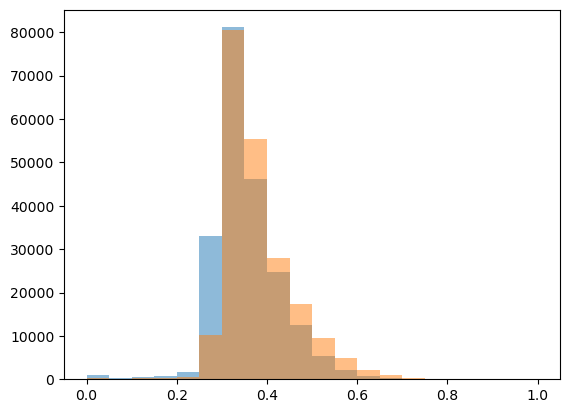

In [28]:
width = 0.05
group = "qsampled"

bins = np.arange(0, 1, width)
dd["bin"] = np.digitize(dd[0], bins)
ddq = (
    dd.query("y==@group")
    .groupby("bin", as_index=False)
    .count()
    .assign(x=bins)[["x", "y"]]
)

group = "m2"
ddm = (
    dd.query("y==@group")
    .groupby("bin", as_index=False)
    .count()
    .assign(x=bins)[["x", "y"]]
)

plt.bar(ddq["x"], ddq["y"], align="edge", width=width, alpha=0.5)
plt.bar(ddm["x"], ddm["y"], align="edge", width=width, alpha=0.5)

In [3]:
dda = pd.concat(
    [
        dd,
        pd.melt(pd.read_csv("mpi_tmp/PTSD_dissonance_matrix.csv"))
        .replace("ptsd", "", regex=True)
        .set_axis(["questions", 0], axis="columns")
        .assign(y="actual"),
    ]
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='value', ylabel='Count'>

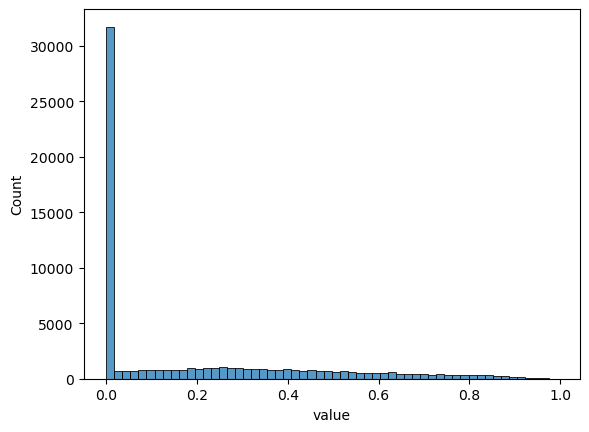

In [6]:
sns.histplot(pd.melt(pd.read_csv("mpi_tmp/PTSD_dissonance_matrix.csv")), x="value")

<AxesSubplot:xlabel='dissonance', ylabel='Count'>

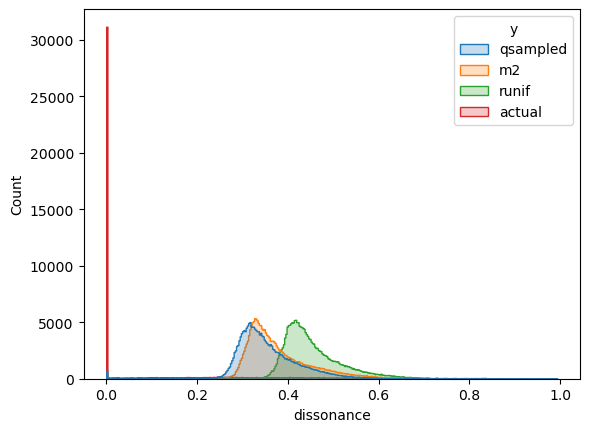

In [13]:
fig, ax = plt.subplots()
sns.histplot(
    dda,
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="count",
    common_norm=True,
    kde=False,
)

<AxesSubplot:xlabel='dissonance', ylabel='Proportion'>

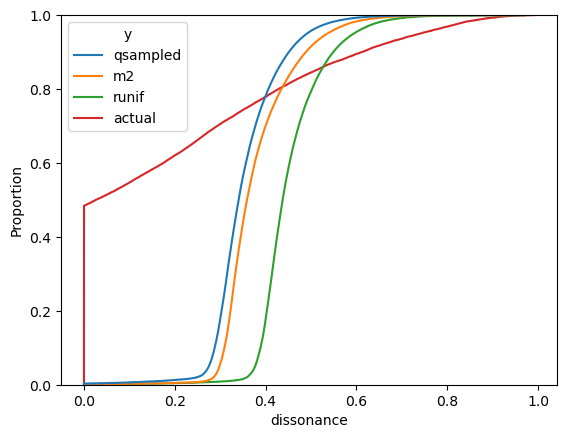

In [4]:
fig, ax = plt.subplots()
sns.ecdfplot(
    dda,
    x="dissonance",
    hue="y",
    ax=ax,
)

In [18]:
dda.groupby("y")["dissonance"]

In [21]:
dda.rename({"y": "group"}, axis="columns")

,dissonance,group,questions
0,0.000000,qsampled,1
1,0.726744,qsampled,1
2,0.726744,qsampled,1
3,0.668605,qsampled,1
4,0.883721,qsampled,1
...,...,...,...
64139,0.052923,actual,211
64140,0.174974,actual,211
64141,0.617431,actual,211
64142,0.000000,actual,211


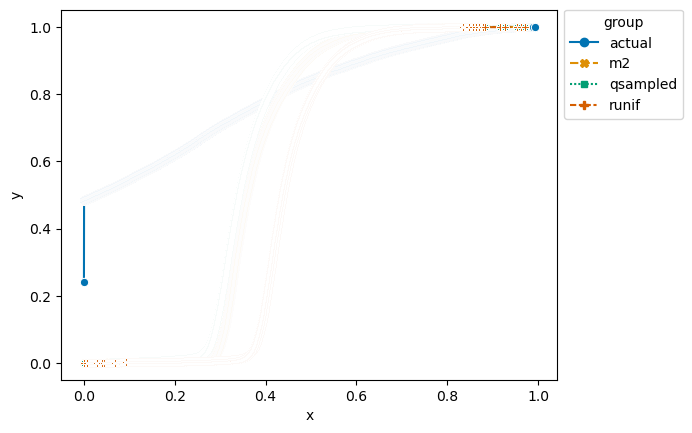

In [23]:
def ecdf(data, array: bool = True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    if not array:
        return pd.DataFrame({"x": x, "y": y})
    else:
        return x, y


# groupy to get the ecdf for each species
dfg = (
    dda.rename({"y": "group"}, axis="columns")
    .groupby("group")["dissonance"]
    .apply(ecdf, False)
    .reset_index(level=0)
    .reset_index(drop=True)
)

# plot
p = sns.lineplot(
    data=dfg,
    x="x",
    y="y",
    hue="group",
    style="group",
    markers=True,
    palette="colorblind",
)
sns.move_legend(p, bbox_to_anchor=(1, 1.02), loc="upper left")

In [25]:
dda["y"].unique()

array(['qsampled', 'm2', 'runif', 'actual'], dtype=object)

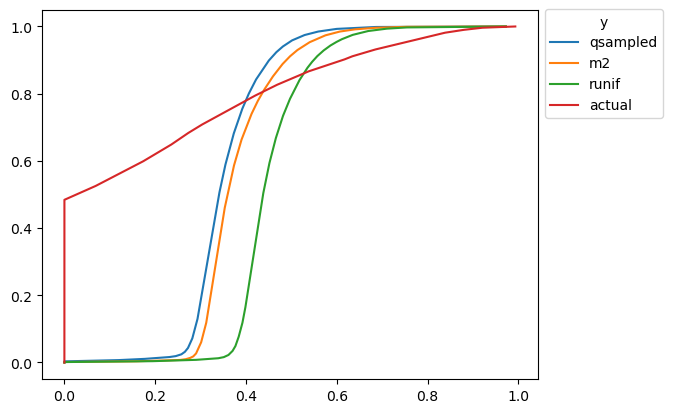

In [99]:
def ecdf(data, array: bool = True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    if not array:
        return pd.DataFrame({"x": x, "y": y})
    else:
        return x, y


fig, ax = plt.subplots()

fraction = 0.1

from pybind11_rdp import rdp

for ygr, marker in zip(dda["y"].unique(), ["*", "*", "o", "+"]):
    x, y = ecdf(dda[dda["y"] == ygr].dissonance)
    data = np.column_stack((x, y))
    datar = rdp(data, epsilon=0.001)
    xs = datar[:, 0]
    ys = datar[:, 1]
    ax.plot(xs, ys, linestyle="-", label=ygr)
plt.legend(title="y", bbox_to_anchor=(1, 1.02), loc="upper left")

In [100]:
len(xs)

17

In [101]:
tpl.save(
    figure=fig,
    filepath="tst.tex",
    extra_axis_parameters=["basegridstyle"],
    standalone=False,
)

In [29]:
tpl.clean_figure(fig)

In [ ]:
print(tpl.get_tikz_code(fig, standalone=False))

In [47]:
pd.DataFrame(
    {0: pd.read_csv("mpi_tmp/PTSD_dissonance_matrix.csv").mean(axis=1), "y": "actual"}
)

,0,y
0,0.185657,actual
1,0.153450,actual
2,0.222102,actual
3,0.138878,actual
4,0.146156,actual
...,...,...
299,0.141303,actual
300,0.307663,actual
301,0.168078,actual
302,0.161679,actual


In [3]:
diss = pd.read_pickle("disson_ptsd/disson_ptsd_qmra_random_order_disson_0.pkl")

In [108]:
groups = ["qsampled", "actual"]

questions_asked = 43
data = _diss_dataset(diss, questions_asked, groups=groups)

In [111]:
data.head(120)

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,y
0,0.647059,0.897872,0.823968,0.722610,0.124874,0.906646,0.476577,0.550397,0.570883,0.000000,...,0.137931,0.833333,0.074074,0.560000,1.000000,0.250000,1.000000,0.500000,0.999040,qsampled
1,0.000000,0.897872,0.315724,0.623299,0.390484,0.209428,0.999254,0.000000,0.000000,0.000000,...,0.994253,0.647059,0.666667,0.000000,1.000000,0.431034,0.000000,1.000000,0.558559,qsampled
2,0.600000,0.000000,0.952979,0.000000,0.399256,0.000000,0.757217,0.633733,0.509276,0.000000,...,0.000000,0.706897,0.000000,1.000000,0.833333,0.227273,0.896685,1.000000,0.999053,qsampled
3,0.800000,0.000000,0.300064,0.871727,0.125938,0.972790,0.773836,0.529780,0.508728,0.000000,...,0.000000,0.000000,0.074074,1.000000,1.000000,0.954545,0.415557,0.666667,0.770000,qsampled
4,0.804642,1.000000,0.315896,0.000000,0.094549,0.000000,0.763020,0.106348,0.570883,0.000000,...,0.994253,0.533333,0.000000,0.000000,0.291667,0.977778,0.766667,0.000000,0.558333,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.823529,0.000000,0.000000,0.788501,0.870088,0.787014,0.000000,0.289336,0.000000,0.000000,...,0.902174,0.520833,0.000000,0.560000,0.833333,0.204545,0.000000,0.533333,1.000000,actual
16,0.555126,0.000000,0.000000,0.000000,0.419587,0.877081,0.000000,0.353591,0.000000,0.550354,...,0.954023,0.357143,0.074074,0.666667,1.000000,0.431034,0.800000,1.000000,0.210526,actual
17,0.228758,0.820988,0.738334,0.000000,0.138399,0.000000,0.478692,0.069659,0.000000,0.550663,...,0.130435,0.000000,0.074074,0.640000,0.000000,0.500000,0.409639,0.500000,0.000000,actual
18,0.555126,1.000000,0.000000,0.000000,0.093285,0.091609,0.000000,0.256918,0.000000,0.000000,...,0.137931,0.403846,0.074074,1.000000,0.000000,0.000000,0.447975,0.000000,0.000000,actual


With actual

In [5]:
for i in tqdm(range(10)):
    disson = pd.read_pickle(f"disson_ptsd/disson_ptsd_qmra_random_order_disson_{i}.pkl")

    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).to_csv(
            f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in range(1, 212)
    ]

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
dffp = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 212)
        for i in range(10)
    ]
)

dffpm = (
    pd.melt(dffp, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dffpm

,y,questions,variable,value
0,qsampled,1,0,0.598837
1,qsampled,1,0,0.936047
2,qsampled,1,0,0.000000
3,qsampled,1,0,0.598837
4,qsampled,1,0,0.000000
...,...,...,...,...
268906835,actual,211,210,0.157000
268906836,actual,211,210,0.000000
268906837,actual,211,210,0.607021
268906838,actual,211,210,0.000000


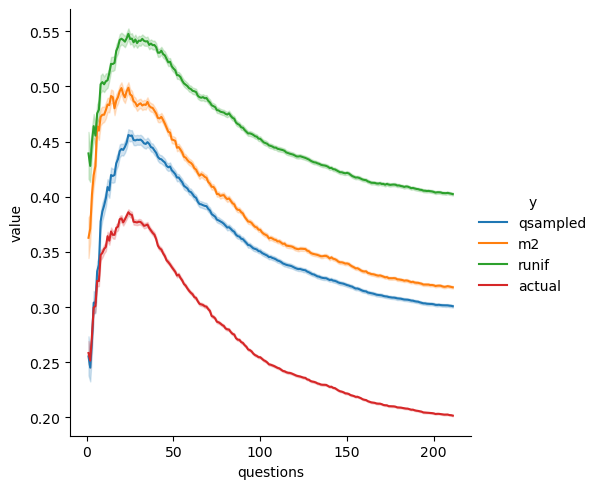

In [4]:
sns.relplot(dffpm, x="questions", y="value", hue="y", kind="line")

In [7]:
res_pdf = list()
conf = 0.95
for questions in tqdm(range(1, 212)):
    for group in ["qsampled", "runif", "m2", "actual"]:
        dfq = dffpm.query("questions==@questions & y==@group")
        mean = dfq["value"].mean()
        var = dfq["value"].var()
        ci = sms.DescrStatsW(dfq["value"]).tconfint_mean(alpha=1 - conf)
        res_pdf.append([group, questions, mean, var, ci[0], ci[1]])

res_pdf = pd.DataFrame(
    res_pdf, columns=["variable", "questions", "mean", "var", "lower", "upper"]
)

res_pdf

  0%|          | 0/211 [00:00<?, ?it/s]

,variable,questions,mean,var,lower,upper
0,qsampled,1,0.255237,0.084923,0.237154,0.273321
1,runif,1,0.439311,0.109357,0.418790,0.459832
2,m2,1,0.362803,0.090175,0.344169,0.381438
3,actual,1,0.258302,0.081947,0.248122,0.268482
4,qsampled,2,0.245064,0.080411,0.232629,0.257499
...,...,...,...,...,...,...
839,actual,210,0.201930,0.067708,0.201292,0.202568
840,qsampled,211,0.300732,0.093189,0.299430,0.302035
841,runif,211,0.402407,0.099880,0.401058,0.403755
842,m2,211,0.317908,0.086715,0.316651,0.319164


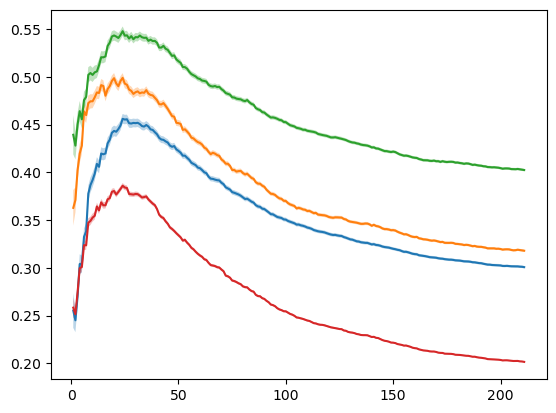

In [8]:
for v in ["qsampled", "m2", "runif", "actual"]:
    df = res_pdf.query("variable==@v")
    plt.plot(df["questions"], df["mean"])
    plt.fill_between(df["questions"], df["lower"], df["upper"], alpha=0.3)

In [9]:
res_pdf.to_csv(
    "data/dissonance_comparison/diss_comp_ptsd_linear_rand_order_melt_with_actual.csv",
    index=False,
)

ECDF:

In [10]:
dffp = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 212)
        for i in range(10)
    ]
)

dd = pd.concat(
    [
        dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffp["y"],
        dffp["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

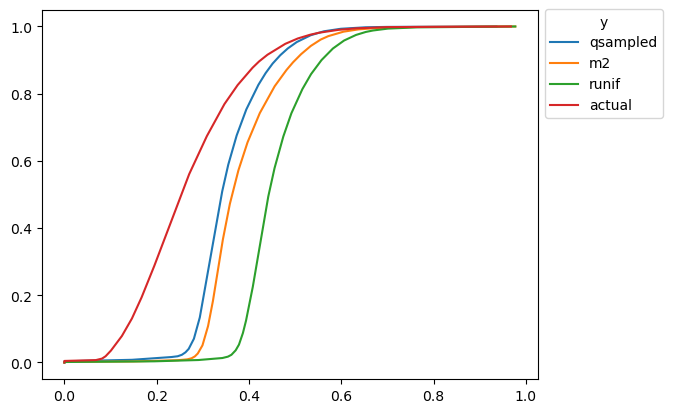

In [14]:
def ecdf(data, array: bool = True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    if not array:
        return pd.DataFrame({"x": x, "y": y})
    else:
        return x, y


fig, ax = plt.subplots()

fraction = 0.1

from pybind11_rdp import rdp

for ygr, marker in zip(dd["y"].unique(), ["*", "*", "o", "+"]):
    x, y = ecdf(dd[dd["y"] == ygr].dissonance)
    data = np.column_stack((x, y))
    datar = rdp(data, epsilon=0.001)
    xs = datar[:, 0]
    ys = datar[:, 1]
    ax.plot(xs, ys, linestyle="-", label=ygr)
plt.legend(title="y", bbox_to_anchor=(1, 1.02), loc="upper left")

In [15]:
tpl.save(
    figure=fig,
    filepath="ptsd-ecdf.tex",
    extra_axis_parameters=["basegridstyle"],
    standalone=False,
)

### Density

In [ ]:
dffp = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 212)
        for i in range(10)
    ]
)

dffpm = (
    pd.melt(dffp, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dffpm

In [17]:
ddp = pd.concat(
    [
        dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffp["y"],
        dffp["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

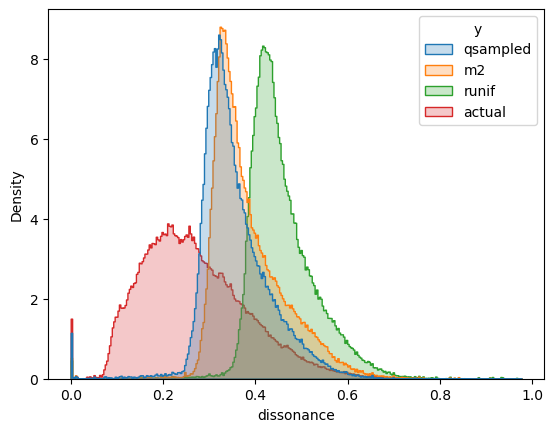

In [19]:
fig, ax = plt.subplots()
sns.histplot(
    ddp.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [21]:
tpl.save(
    figure=fig,
    filepath="ptsd-pdf.tex",
    extra_axis_parameters=[
        "basegridstyle",
        "ignore legend",
        "title={PTSD}",
    ],
    standalone=False,
)

Final diss only

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

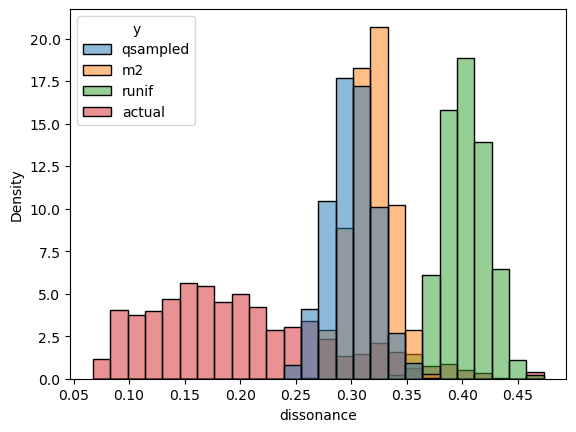

In [5]:
dffp = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_ptsd/csv/{i}/disson_qmra_ptsd_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(211, 212)
        for i in range(10)
    ]
)

dffpm = (
    pd.melt(dffp, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

ddp = pd.concat(
    [
        dffp.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffp["y"],
        dffp["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    ddp.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    # element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [ ]:
tpl.save(
    figure=fig,
    filepath="ptsd-pdf-last.tex",
    extra_axis_parameters=[
        "basegridstyle",
        "ignore legend",
        "title={PTSD}",
    ],
    standalone=False,
)

## New

### Dx

In [11]:
basepath = "disson_new/ptsd/dx/disson_ptsd_qmra/"
_process_csvs(basepath, 212, get_csvs=True)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

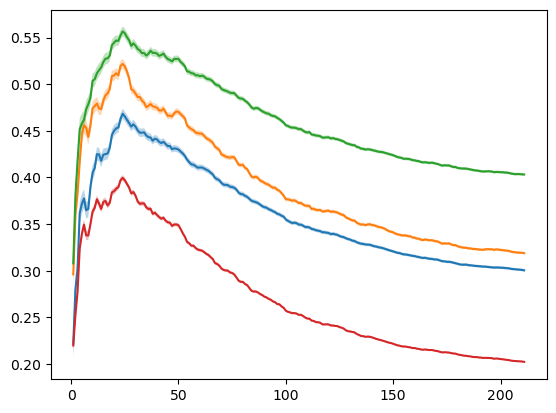

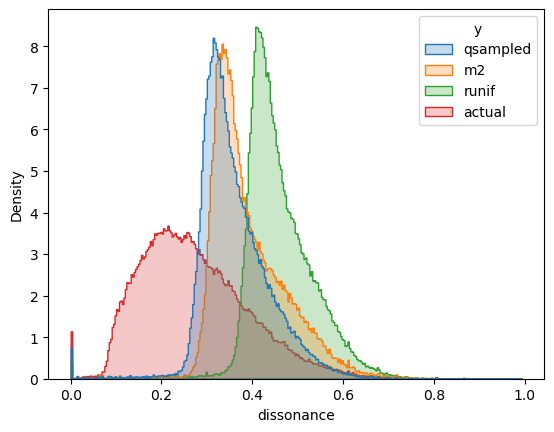

In [18]:
_plot_diss_dist(
    dffgm=pd.read_csv(f"{basepath}dffgm.csv"),
    dd=pd.read_csv(f"{basepath}dd.csv"),
    num_questions=212,
    outfile="data/dissonance_comparison/diss_comp_ptsd_dx_linear_rand_order_melt_new_m2.csv",
    outfig=basepath
)

### Core

# Global

## Old

In [4]:
diss = pd.read_pickle("disson_global/disson_global_qmra_random_order_disson_0.pkl")

groups = ["qsampled", "actual"]

questions_asked = 43
data = _diss_dataset(diss, questions_asked, groups=groups)

In [6]:
data

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,y
0,0.000000,0.000000,0.0,0.5,0.0,0.000000,0.0000,1.0,0.28125,0.000000,...,1.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.514768,0.0000,qsampled
1,0.881356,0.000000,0.0,0.0,0.0,0.000000,0.6875,0.0,0.00000,0.891892,...,0.0,0.000000,0.0,0.918919,0.000000,1.0,0.000000,0.000000,0.7500,qsampled
2,0.000000,0.000000,0.0,0.0,0.0,0.666667,0.0000,0.0,0.00000,0.000000,...,0.0,0.666667,0.0,0.000000,0.000000,0.0,1.000000,0.514768,0.0000,qsampled
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.28125,0.000000,...,0.0,0.000000,0.0,0.916667,0.000000,0.0,0.000000,0.000000,0.0000,qsampled
4,0.881356,0.000000,0.5,0.5,0.0,0.666667,0.0000,0.0,0.00000,0.891892,...,1.0,0.666667,0.0,0.918919,0.787879,0.0,1.000000,0.000000,0.8125,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,0.570064,NaN,NaN,NaN,0.000000,NaN,actual
1232,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.700422,NaN,actual
1233,NaN,0.367559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.570064,NaN,NaN,NaN,0.700422,NaN,actual
1234,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,0.920000,0.000000,NaN,actual


In [12]:
for i in tqdm(range(7, 10)):
    disson = pd.read_pickle(
        f"disson_global/disson_global_qmra_random_order_disson_{i}.pkl"
    )

    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).to_csv(
            f"disson_global/csv/{i}/disson_qmra_global_random_order_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in range(1, 345)
    ]

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/csv/{i}/disson_qmra_global_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/csv/{i}/disson_qmra_global_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 345)
        for i in range(10)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

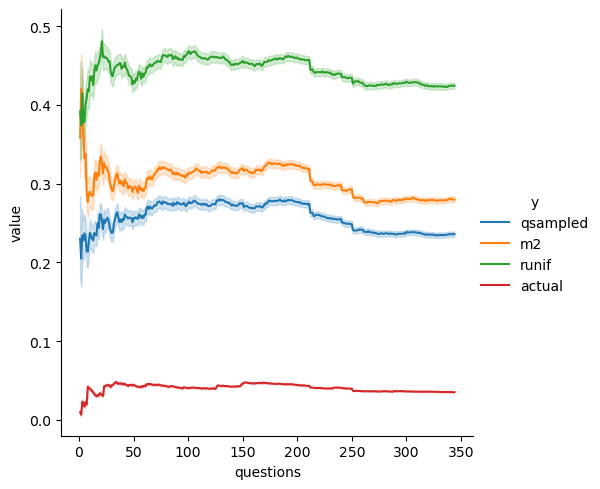

In [7]:
sns.relplot(dffgm, x="questions", y="value", hue="y", kind="line")

In [9]:
res_gdf = list()
conf = 0.95
for questions in tqdm(range(1, 345)):
    for group in ["qsampled", "runif", "m2", "actual"]:
        dfgq = dffgm.query("questions==@questions & y==@group")
        mean = dfgq["value"].mean()
        var = dfgq["value"].var()
        ci = sms.DescrStatsW(dfgq["value"]).tconfint_mean(alpha=1 - conf)
        res_gdf.append([group, questions, mean, var, ci[0], ci[1]])

res_gdf = pd.DataFrame(
    res_gdf, columns=["variable", "questions", "mean", "var", "lower", "upper"]
)

res_gdf

  0%|          | 0/344 [00:00<?, ?it/s]

,variable,questions,mean,var,lower,upper
0,qsampled,1,0.164788,0.043801,0.135605,0.193970
1,runif,1,0.448968,0.139725,0.396847,0.501090
2,m2,1,0.277748,0.070657,0.240683,0.314812
3,actual,1,0.178597,0.045589,0.160664,0.196530
4,qsampled,2,0.156041,0.055572,0.132869,0.179213
...,...,...,...,...,...,...
1371,actual,343,0.190372,0.080309,0.188976,0.191767
1372,qsampled,344,0.237141,0.101041,0.234766,0.239517
1373,runif,344,0.424300,0.139128,0.421513,0.427087
1374,m2,344,0.280237,0.111844,0.277738,0.282736


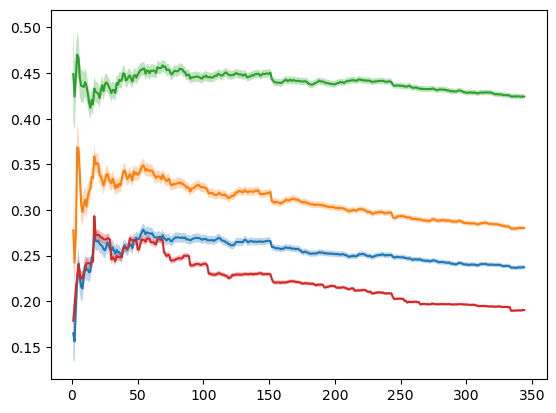

In [10]:
for v in ["qsampled", "m2", "runif", "actual"]:
    df = res_gdf.query("variable==@v")
    plt.plot(df["questions"], df["mean"])
    plt.fill_between(df["questions"], df["lower"], df["upper"], alpha=0.3)

In [11]:
res_gdf.to_csv(
    "data/dissonance_comparison/global/diss_comp_global_linear_rand_order_melt_with_actual.csv",
    index=False,
)

ECDF:

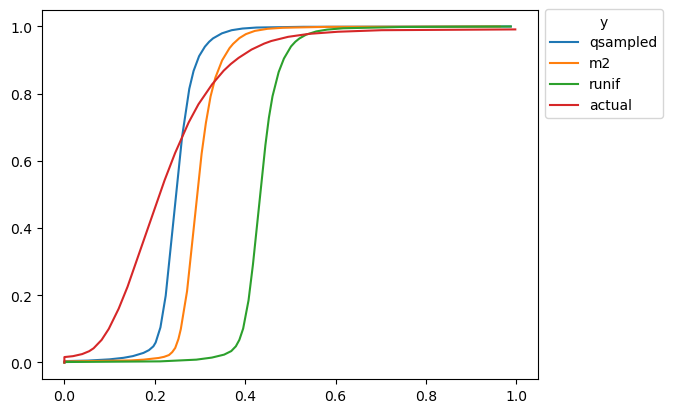

In [49]:
def ecdf(data, array: bool = True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    if not array:
        return pd.DataFrame({"x": x, "y": y})
    else:
        return x, y


fig, ax = plt.subplots()

fraction = 0.1

from pybind11_rdp import rdp

for ygr, marker in zip(dd["y"].unique(), ["*", "*", "o", "+"]):
    x, y = ecdf(dd[dd["y"] == ygr].dissonance)
    data = np.column_stack((x, y))
    data = data[~np.isnan(data).any(axis=1)]
    datar = rdp(data, epsilon=0.001)
    xs = datar[:, 0]
    ys = datar[:, 1]
    ax.plot(xs, ys, linestyle="-", label=ygr)
plt.legend(title="y", bbox_to_anchor=(1, 1.02), loc="upper left")

In [ ]:
tpl.save(
    figure=fig,
    filepath="global-ecdf.tex",
    extra_axis_parameters=[
        "basegridstyle",
        "ignore legend",
        "title={Global}",
    ],
    standalone=False,
)

In [38]:
dd

,dissonance,y,questions
0,0.000000,qsampled,1
1,0.231707,qsampled,1
2,0.231707,qsampled,1
3,0.060976,qsampled,1
4,0.060976,qsampled,1
...,...,...,...
1531,0.266136,actual,344
1532,0.185496,actual,344
1533,0.227104,actual,344
1534,0.192811,actual,344


In [37]:
dd.query("dissonance.notnull()")

,dissonance,y,questions
0,0.000000,qsampled,1
1,0.231707,qsampled,1
2,0.231707,qsampled,1
3,0.060976,qsampled,1
4,0.060976,qsampled,1
...,...,...,...
1531,0.266136,actual,344
1532,0.185496,actual,344
1533,0.227104,actual,344
1534,0.192811,actual,344


In [20]:
dd.query("y.isin(['qsampled','actual'])")

,dissonance,y,questions
0,0.000000,qsampled,1
1,0.231707,qsampled,1
2,0.231707,qsampled,1
3,0.060976,qsampled,1
4,0.060976,qsampled,1
...,...,...,...
1531,0.266136,actual,344
1532,0.185496,actual,344
1533,0.227104,actual,344
1534,0.192811,actual,344


In [18]:
dd["y"]

0       qsampled
1       qsampled
2       qsampled
3       qsampled
4       qsampled
          ...   
1531      actual
1532      actual
1533      actual
1534      actual
1535      actual
Name: y, Length: 3698688, dtype: object

In [ ]:
tpl.save(
    figure=fig,
    filepath="global-ecdf.tex",
    extra_axis_parameters=["basegridstyle"],
    standalone=False,
)

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

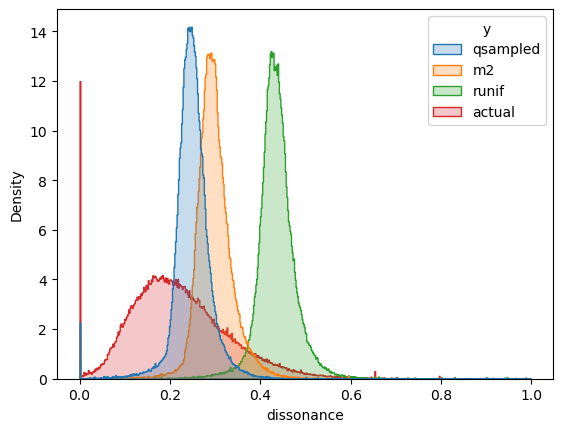

In [14]:
fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [15]:
tpl.save(
    figure=fig,
    filepath="global-pdf.tex",
    extra_axis_parameters=[
        "basegridstyle",
        "ignore legend",
        "title={Global}",
    ],
    standalone=False,
)

In [ ]:
fig

In [33]:
dd.query('y=="actual" & dissonance.isnull()')

,dissonance,y,questions
300,NaN,actual,1
302,NaN,actual,1
303,NaN,actual,1
305,NaN,actual,1
306,NaN,actual,1
...,...,...,...
918,NaN,actual,32
646,NaN,actual,33
918,NaN,actual,33
918,NaN,actual,34


In [34]:
dd.query('y=="actual" & dissonance == 0')

,dissonance,y,questions
301,0.0,actual,1
309,0.0,actual,1
345,0.0,actual,1
360,0.0,actual,1
365,0.0,actual,1
...,...,...,...
1113,0.0,actual,95
1113,0.0,actual,96
1113,0.0,actual,97
1113,0.0,actual,98


In [10]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/csv/{i}/disson_qmra_global_random_order_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/csv/{i}/disson_qmra_global_random_order_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(344, 345)
        for i in range(2, 3)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

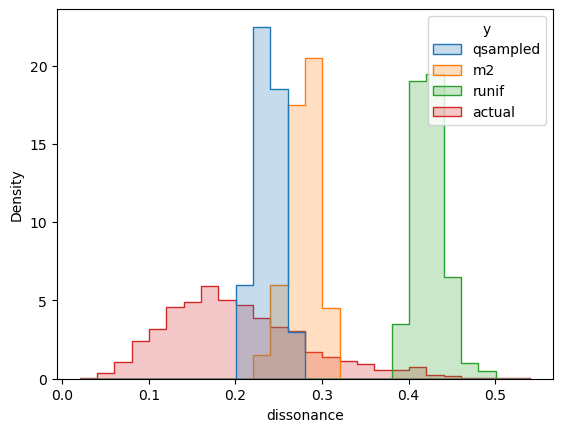

In [11]:
fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

## New

### Core

In [8]:
basepath = "disson_new/global/core/disson_global_qmra_missing_0/"
_process_csvs(basepath, 390, get_csvs=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

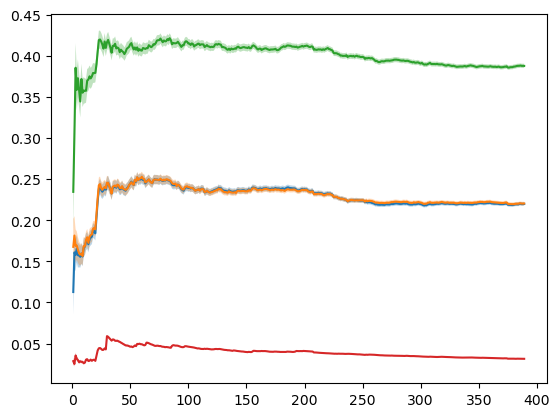

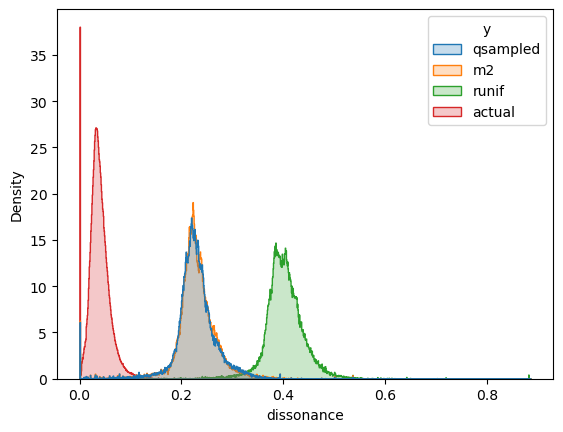

: 

In [10]:
_plot_diss_dist(
    dffgm=pd.read_csv(f"{basepath}dffgm.csv"),
    dd=pd.read_csv(f"{basepath}dd.csv"),
    num_questions=390,
    outfile="data/dissonance_comparison/diss_comp_global_core_linear_rand_order_missing_0_melt_new_m2.csv",
    outfig=basepath
)

### Dx

In [19]:
basepath = "disson_new/global/dx/disson_global_qmra_missing_0/"

In [ ]:
_process_csvs(basepath, 345, get_csvs=True)

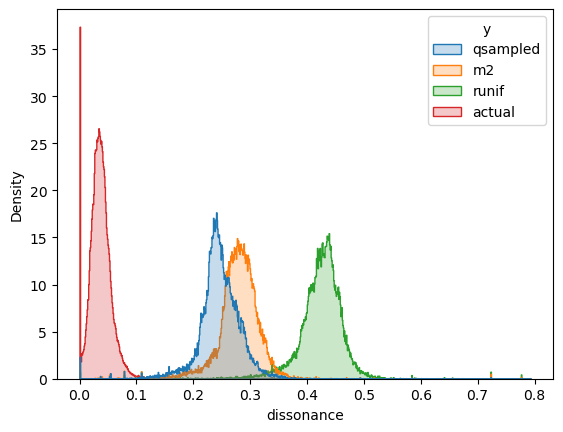

: 

In [22]:
_plot_diss_dist(
    dffgm=pd.read_csv(f"{basepath}dffgm.csv"),
    dd=pd.read_csv(f"{basepath}dd.csv"),
    num_questions=345,
    outfile="data/dissonance_comparison/diss_comp_global_dx_linear_rand_order_missing_0_melt_new_m2.csv",
    plots=["diss-distr"],
    outfig=basepath
)

# Bond court

In [4]:
_process_csvs("disson_new/bondcourt/core/disson_bond_qmra_missing_0/", 43, get_csvs=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

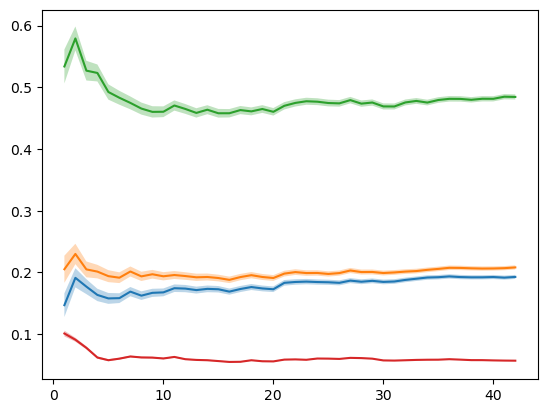

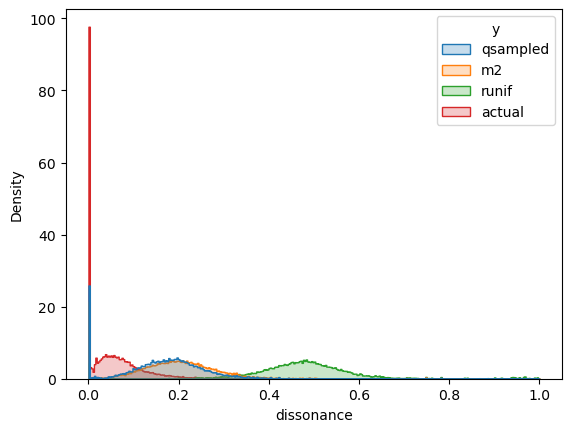

In [5]:
_plot_diss_dist(
    dffgm=pd.read_csv("disson_new/bondcourt/core/disson_bond_qmra_missing_0/dffgm.csv"),
    dd=pd.read_csv("disson_new/bondcourt/core/disson_bond_qmra_missing_0/dd.csv"),
    num_questions=43,
    outfile="data/dissonance_comparison/diss_comp_bondcourt_core_linear_rand_order_missing_0_melt_new_m2.csv",
    outfig="disson_new/bondcourt/core/disson_bond_qmra_missing_0/"
)